# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from skimage.feature import match_template

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
print(ROOT_DIR)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

import mrcnn.utils
import mrcnn.model as modellib
from mrcnn import visualize


sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))
print(sys.path)
import coco
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/home/yzn/CV/Mask_RCNN
['', '/home/yzn/miniconda3/envs/elf/lib/python36.zip', '/home/yzn/miniconda3/envs/elf/lib/python3.6', '/home/yzn/miniconda3/envs/elf/lib/python3.6/lib-dynload', '/home/yzn/.local/lib/python3.6/site-packages', '/home/yzn/miniconda3/envs/elf/lib/python3.6/site-packages', '/home/yzn/RL/gym', '/home/yzn/miniconda3/envs/elf/lib/python3.6/site-packages/IPython/extensions', '/home/yzn/.ipython', '/home/yzn/CV/Mask_RCNN', '/home/yzn/CV/Mask_RCNN', '/home/yzn/CV/Mask_RCNN/samples/coco/']


Using TensorFlow backend.


In [2]:
import tensorflow as tf
import keras.backend.tensorflow_backend as ktf


def get_session(gpu_fraction=0.333):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction,
                                allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


ktf.set_session(get_session())

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      

## Create Model and Load Trained Weights

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (480, 640, 3)         min:    1.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


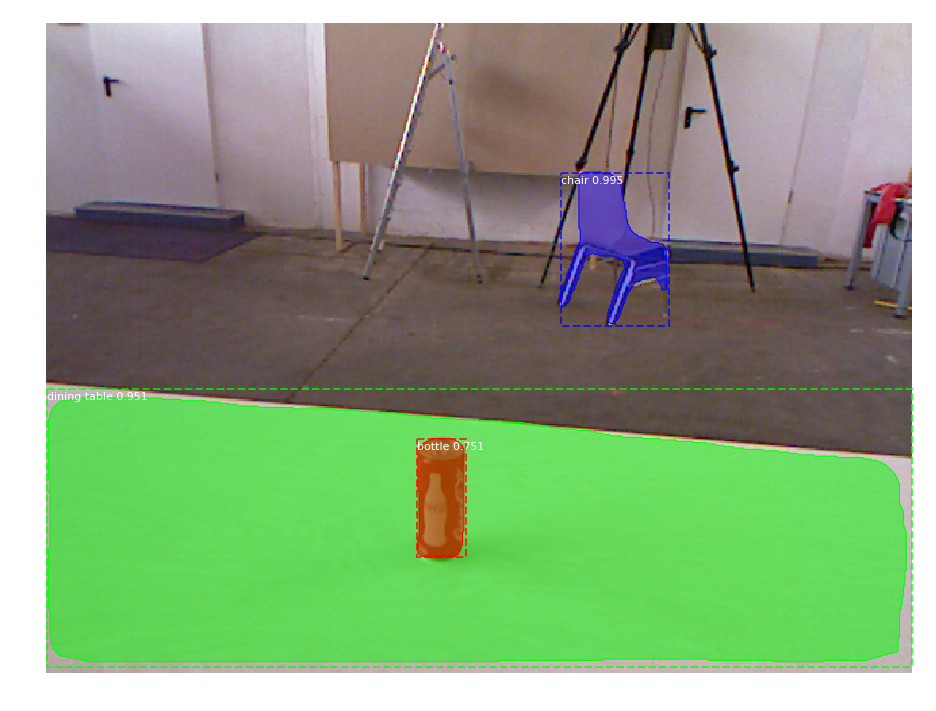

--- 2.050654411315918 seconds ---


In [6]:
import time
start_time = time.time()



# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
#image1 = skimage.io.imread('1311871923.036248.png')
#image1 = skimage.io.imread('1311871955.371639.png')

image1 = skimage.io.imread('1311871965.975433.png')
#image = skimage.io.imread('coke_test/rgb/1311871927.668086.png')

#image = image[216:300,309:354,:]
#226 286 319 324
# Run detection
#for i in range(50):
results = model.detect([image1], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image1, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# Visualize results
# r2 = results[1]
# visualize.display_instances(image2, r2['rois'], r2['masks'], r2['class_ids'], 
#                             class_names, r2['scores'])

print("--- %s seconds ---" % (time.time() - start_time))

In [7]:
from mask_detect import mask_detect

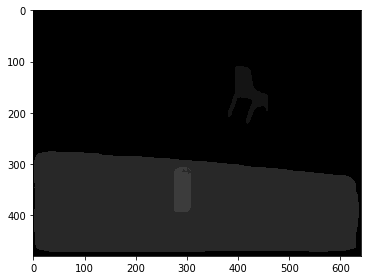

In [8]:
rgb_img = skimage.io.imread('1311871965.975433.png')
dep_img = skimage.io.imread('1311871965.993806.png')
cls = mask_detect(model, rgb_img, dep_img)
skimage.io.imshow(cls*20)

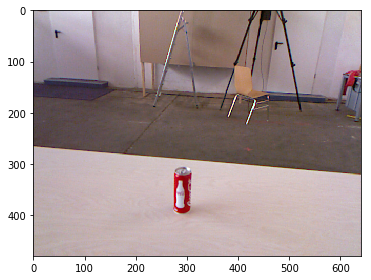

In [9]:
skimage.io.imshow(image1)

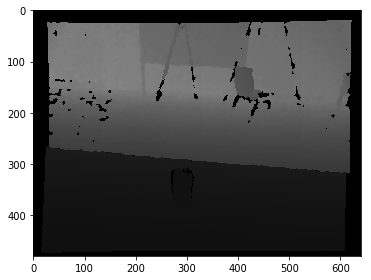

In [10]:
skimage.io.imshow(dep_img)

In [17]:
np.argsort(np.array([3672,110061,2822]))

array([2, 0, 1])

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  254.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


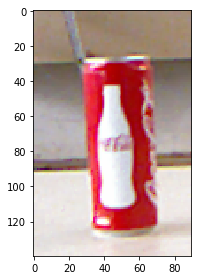

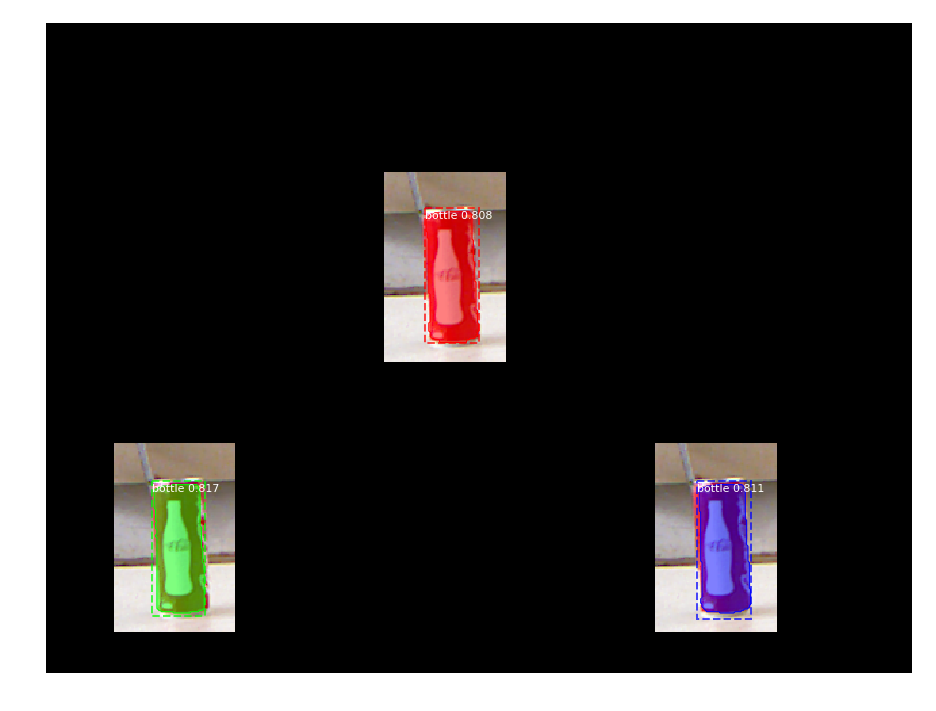

In [292]:
t_image = image[110:250,250:340,:]
skimage.io.imshow(t_image)

target_image = np.zeros(image.shape, dtype=np.uint8)
target_image[110:250,250:340,:] = t_image

target_image[310:450,450:540,:] = t_image

target_image[310:450,50:140,:] = t_image
results = model.detect([target_image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(target_image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])


## Template match for undetected frame
### function for find minimum rectangle bouding region

In [184]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

In [185]:
def pick_mask(all_mask, class_ids, class_names, chosen_class_name):
    target_mask = None
    for i in range(class_ids.shape[0]):
        if class_names[class_ids[i]] == chosen_class_name:
            target_mask = all_mask[:,:,i]
            break
    return target_mask

In [186]:
def depth_filter(depth_image, rgb_image, target_mask, target_rois, range=3000):
    rmin, cmin, rmax, cmax = target_rois
    new_mask = target_mask.copy()
    dep_target = depth_image[rmin:rmax, cmin:cmax]
    std_val = np.median(dep_target)
    dep_filter = (depth_image < std_val-range) | (depth_image > std_val+range)
    new_mask[dep_filter] = 0
    new_rois = bbox2(new_mask)
    return new_mask, new_rois

In [222]:
def template_match_mask_detect(model, rgb_image, pre_target, expand_ratio=0.1):
    row = rgb_image.shape[0]
    col = rgb_image.shape[1]
    matches = skimage.feature.match_template(rgb_image, pre_target)
    ij = np.unravel_index(np.argmax(matches), matches.shape)
    match_rmin, match_cmin = ij[:-1]
    h_target, w_target,_ = target.shape
    crop_rmin = int(max(0,match_rmin - h_target * expand_ratio))
    crop_cmin = int(max(0,match_cmin - h_target * expand_ratio))
    crop_rmax = int(min(rgb_image.shape[0], match_rmin + h_target * (1 + expand_ratio)))
    crop_cmax = int(min(rgb_image.shape[1], match_cmin + w_target * (1 + expand_ratio)))

    expand_target = rgb_image[crop_rmin:crop_rmax, crop_cmin:crop_cmax, :]
    # the rois and masks here only partial, need to expand to full iamge size
    rois, masks, class_ids, scores = mask_detect(model, expand_target)
    num_objects = class_ids.shape[0]
    full_rois = rois + np.array([crop_rmin, crop_cmin, crop_rmin, crop_cmin])
    full_masks = np.zeros((row, col, num_objects),dtype=np.int8)
    full_masks[crop_rmin:crop_rmax, crop_cmin:crop_cmax, :] = masks

    return full_rois, full_masks, class_ids, scores


In [229]:
def calc_overlap_ratio(direct_roi, match_roi):
    XA1, YA1, XA2, YA2 = direct_roi
    XB1, YB1, XB2, YB2 = match_roi
    SI= max(0, min(XA2, XB2) - max(XA1, XB1)) * max(0, min(YA2, YB2) - max(YA1, YB1))
    SA = (XA2 - XA1) * (YA2 - YA1)
    SB = (XB2 - XB1) * (YB2 - YB1)
    ratio = SI / (SA + SB - SI)
    return ratio

In [228]:
def save_mask_images(rgb_image, dir, rgb_file_name, mask_image=None, gray_image=None, class_name="none"):
    if class_name == "none":
        row = rgb_image.shape[0]
        col = rgb_image.shape[1]
        mask_image = gray_image = np.zeros((row, col, 3), dtype=np.int8)
    file_name = class_name + '_' + rgb_file_name
    plt.imsave(join(join(dir,'rgb_mask'),file_name), mask_image)
    plt.imsave(join(join(dir,'gray_mask'),file_name), gray_image)   

In [204]:
def mask_detect(model, rgb_image):
    results = model.detect([rgb_image], verbose=0)
    r = results[0]
    return r['rois'], r['masks'], r['class_ids'], r['scores']

In [231]:
if r['class_ids'] is None:
    print(1)
else:
    print(2)

2


(169, 261, 184, 221)


/home/yzn/miniconda3/envs/elf/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


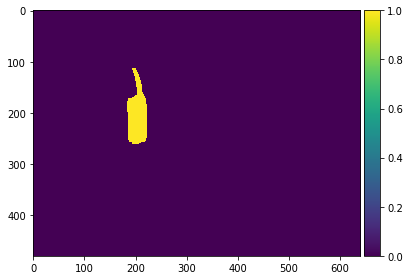

In [187]:
dep_image = skimage.io.imread('coke_test/depth/1311871927.624490.png')

new_mask, new_rois = depth_filter(dep_image, image, r['masks'][:,:,1],r['rois'][1])
skimage.io.imshow(r['masks'][:,:,1])
print(new_rois)

### get target template from previous image

In [137]:


target_mask = pick_mask(r['masks'], r['class_ids'], class_names, 'bottle')

#rmin, rmax, cmin, cmax = bbox2(target_mask)

rmin, cmin,rmax, cmax = r['rois'][1]
print(rmin, rmax, cmin, cmax)
target = image[rmin:rmax, cmin:cmax, :]




138 237 279 321


In [198]:
row = image.shape[0]
col = image.shape[1]
s = np.zeros((row,col,2), dtype=np.int8)
s[0:row,0:col,:] = r['masks']

In [149]:
r['masks'][:,:,1]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [141]:
dep_image = skimage.io.imread('1311871922.983782.png')

dep_target = dep_image[rmin:rmax, cmin:cmax]

np.median(dep_target)

# for i in range(rmin-1, rmax+10):
#     print(dep_image[i,cmin:cmax])




3991.0

### template match image in next image, expand this area and do mask-RCNN again

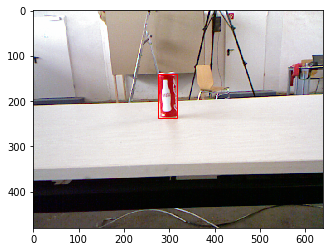

139 238 276 318
129 247 266 322


In [188]:
next_image = skimage.io.imread('1311871923.036248.png')

matches = skimage.feature.match_template(next_image, target)
ij = np.unravel_index(np.argmax(matches), matches.shape)
match_rmin, match_cmin = ij[:-1]
h_target, w_target,_ = target.shape
crop_rmin = int(max(0,match_rmin - h_target * 0.1))
crop_cmin = int(max(0,match_cmin - h_target * 0.1))
crop_rmax = int(min(next_image.shape[0], match_rmin + h_target * 1.1))
crop_cmax = int(min(next_image.shape[1], match_cmin + w_target * 1.1))

expand_target = next_image[crop_rmin:crop_rmax, crop_cmin:crop_cmax, :]


fig,ax = plt.subplots(1)
h_target, w_target,_ = target.shape
ax.imshow(next_image)
rect = plt.Rectangle((match_cmin,match_rmin), w_target, h_target, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()


print(match_rmin, match_rmin + h_target, match_cmin, match_cmin + w_target)
print(crop_rmin, crop_rmax, crop_cmin, crop_cmax)




[42] 1 1 1


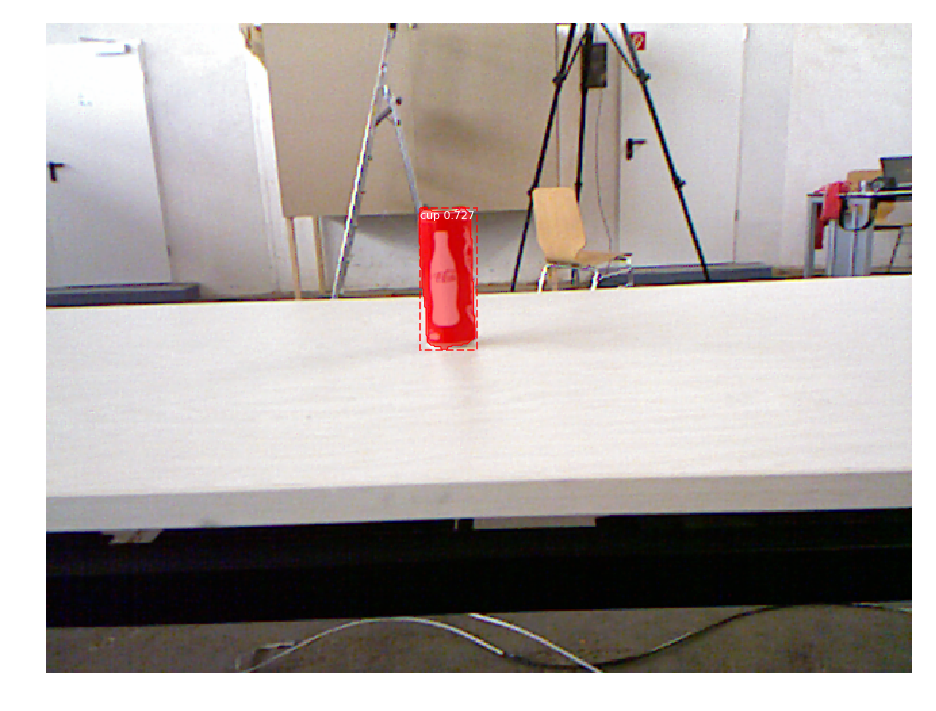

In [226]:
full_rois, full_masks, class_ids, scores = template_match_mask_detect(model, next_image, target,0.4)
print(class_ids,full_rois.shape[0],full_masks.shape[-1],class_ids.shape[0])


visualize.display_instances(next_image, full_rois, full_masks, class_ids,
                            class_names, scores)

Processing 1 images
image                    shape: (115, 54, 3)          min:    1.00000  max:  254.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


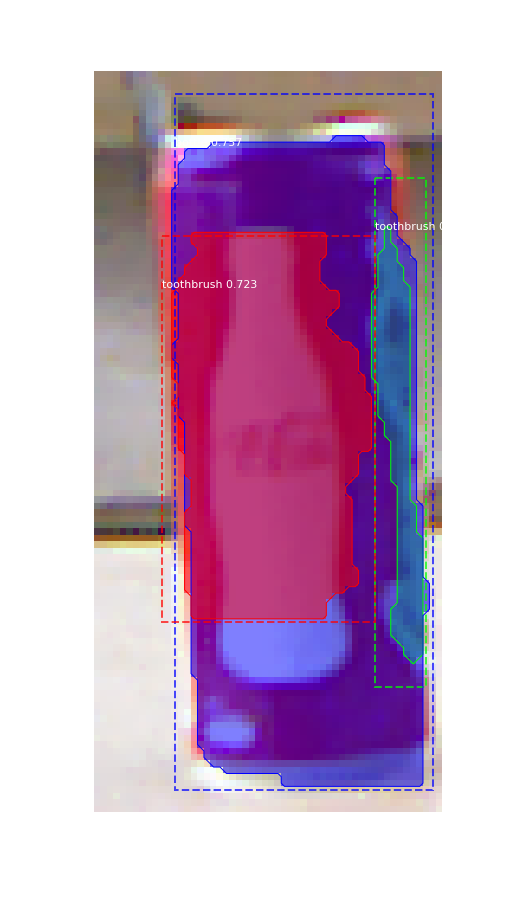

In [90]:
test_result = model.detect([expand_target], verbose=1)

# Visualize results
new_r = test_result[0]
visualize.display_instances(expand_target, new_r['rois'], new_r['masks'], new_r['class_ids'], 
                            class_names, new_r['scores'])

In [106]:
depth_img = skimage.io.imread('coke_test/depth/1311871927.624490.png')
print(np.max(depth_img))


44885


In [140]:
print(new_r['class_ids'])
for i in new_r['class_ids']:
    print(class_names[i])
print(expand_target.shape)
image.shape[0]

[80 40 80]
toothbrush
bottle
toothbrush
(118, 56, 3)


480

In [123]:
from os import listdir
from os.path import isfile, join
rgb_dir = 'coke_test/rgb'
rgb_files = [f for f in listdir(rgb_dir) if isfile(join(rgb_dir, f))]

start_index = 1


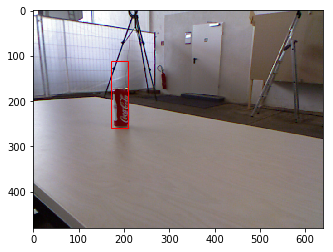

In [41]:
next_image = skimage.io.imread(join(rgb_dir,rgb_files[start_index]))
matches = skimage.feature.match_template(next_image, target)
ij = np.unravel_index(np.argmax(matches), matches.shape)
x, y = ij[:-1]
fig,ax = plt.subplots(1)
h_target, w_target,_ = target.shape
ax.imshow(next_image)
rect = plt.Rectangle((y,x), w_target, h_target, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()
start_index += 1
#target = next_image[]

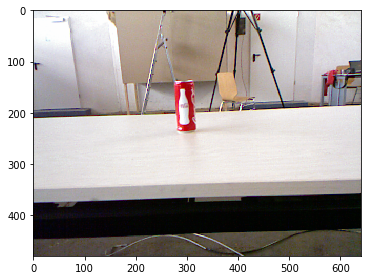

In [10]:
next_image = skimage.io.imread('1311871923.036248.png')
skimage.io.imshow(next_image)

In [11]:



#print(r['masks'])
print(r['class_ids'])
for i in r['class_ids']:
    print(class_names[i])


[57 40]
chair
bottle


In [8]:
t = r['masks'][:,:,1]
s = np.dstack([t,t,t])
test_image = np.multiply(image, s)

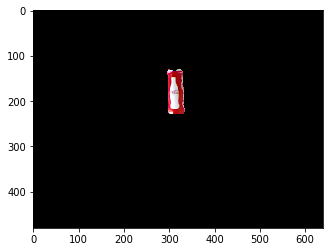

In [8]:
plt.imshow(test_image)

In [9]:
print(image.shape)
print(r['masks'][:,:,1].shape)

(480, 640, 3)
(480, 640)


In [10]:
x1 = np.arange(9.0).reshape((3, 3))
x2 = np.arange(3.0)
np.multiply(x1, x2)

array([[  0.,   1.,   4.],
       [  0.,   4.,  10.],
       [  0.,   7.,  16.]])

In [11]:
print(x1.shape)
print(x2.shape)

(3, 3)
(3,)


In [13]:
from random import randint

In [22]:
randint(0,254)

6

In [37]:
t = r['masks'][:,:,1]
s = np.dstack([(t*randint(0,254)),(t*randint(0,254)),(t*randint(0,254))])

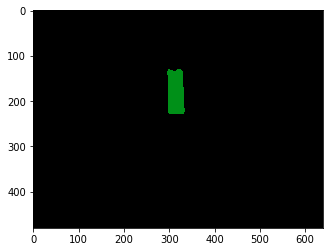

In [38]:
g = s * 200
plt.imshow(g)

In [14]:
os.path.join(os.getcwd(), 'sf')

'/home/yzn/CV/Mask_RCNN/sf'

In [15]:
len(results)

1

In [16]:
[f for f in os.listdir(os.getcwd()) if os.path.isfile(os.path.join(os.getcwd(), f))]

['.gitignore',
 'visualize.py',
 '1311871922.668414.png',
 'mask_rcnn_coco.h5',
 'train_shapes.ipynb',
 'inspect_weights.ipynb',
 'config.py',
 'inspect_data.ipynb',
 'LICENSE',
 'parallel_model.py',
 'shapes.py',
 'coco.py',
 'mask_image.py',
 'README.md',
 'utils.py',
 'inspect_model.ipynb',
 'model.py',
 'demo.ipynb',
 'test.jpeg']